In [11]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def split(word):
    return[char for char in word]

In [3]:
def generations_counter(input_data, num_generations): #function which returns arrays containing the generation numbers and index of the last match of each generation, passed the matches dataframe and number of generations of the network
    gen_data = np.zeros(num_generations+1)
    value_data = np.zeros(num_generations+1)

    for i in range(len(gen_data)):
        gen_data[i] = i #sets the generation numbers for the network

    for i in range(len(input_data['Generation'])):
        if type(input_data['Generation'][i]) == str:
            dummy = split(input_data['Generation'][i])
            value = int(dummy[-1])
        else:
            value = input_data['Generation'][i]
        value_data[value]+=1 #identifies the number of matches of each generation

    final_value_data = np.zeros(num_generations+1)
    final_value_data[0] = value_data[0]
    for i in range(1, len(value_data)):
        final_value_data[i] += value_data[i]
        for j in range(i):
            final_value_data[i] += value_data[j] #identifies the cumulative number of matches up to the end of each generation (including all prior generations)

    return(gen_data, final_value_data)

In [4]:
def counter(filepath, num_gens): #function which counts the number of spont vs non-spont matches, passed filepath for a network's pathway summary and the no. generations to consider
  input_data = pd.read_csv(filepath, sep='\t')
  gen_data = (generations_counter(input_data, num_gens))[1]

  spont_counter = np.zeros(num_gens)
  nonspont_counter = np.zeros(num_gens)

  for i in range(1, len(gen_data)): #iterates over generations to be considered
    for j in range(int(gen_data[i])): #iterates over all molecules to the end of the generation currently under consideration
      if input_data['PathwayFound?'][j] == True:
        spont_counter[i-1] += 1
      nonspont_counter[i-1] += 1
  return([spont_counter, nonspont_counter]) #returns arrrays containing the cumulative no. spont and non-spont matches up to the end of each generation

In [5]:
def spont_vs_nonspont(networks, num_gens): #function which produces a dataframe containing the cumulative no. spont and non-spont matches of each network by the end of each generation
  spont_data = []
  nonspont_data = []

  for i in range(len(networks)):
    filepath = f'/content/drive/MyDrive/BMSIS /MinimalDirectory/ProcessedData/PathwaySummaries/{networks[i]}PathwaysSummary.tsv'
    dummy = counter(filepath, num_gens)
    spont_data.append(dummy[0])
    nonspont_data.append(dummy[1])
  df = pd.DataFrame({'Formose_S':spont_data[0], 'Formose_NS':nonspont_data[0], 'FormoseAmm_S':spont_data[1],\
                     'FormoseAmm_NS':nonspont_data[1], 'Glucose_S':spont_data[2], 'Glucose_NS':nonspont_data[2],\
                     'GlucoseAmm_S':spont_data[3], 'GlucoseAmm_NS':nonspont_data[3], 'PyruvicAcid_S':spont_data[4],\
                     'PyruvicAcid_NS':nonspont_data[4]})

  df.columns = df.columns.str.split('_', expand=True) #raises network titles to higher level of datafrane column names (so spont and non-spont become subtitles)
  df.insert(0, 'Generation', np.arange(1, num_gens+1))
  df.to_csv('/content/drive/MyDrive/BMSIS /MinimalDirectory/ProcessedData/SpontVsNonSpont.tsv', index=False, sep='\t')
  return(df)

In [6]:
%%time
a = spont_vs_nonspont(['Formose', 'FormoseAmm', 'Glucose', 'GlucoseAmm', 'PyruvicAcid'], 3)

CPU times: user 97.7 ms, sys: 4.45 ms, total: 102 ms
Wall time: 3.27 s


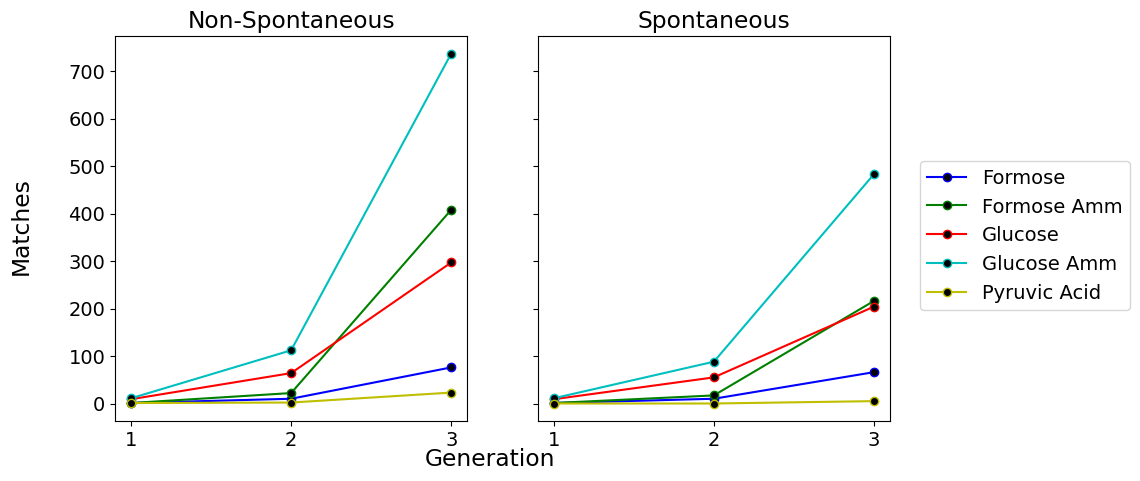

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
ax1.plot(a['Generation'], a['Formose']['NS'], '-o', c='b', markerfacecolor='k')
ax1.plot(a['Generation'], a['FormoseAmm']['NS'], '-o', c='g', markerfacecolor='k')
ax1.plot(a['Generation'], a['Glucose']['NS'], '-o', c='r', markerfacecolor='k')
ax1.plot(a['Generation'], a['GlucoseAmm']['NS'], '-o', c='c', markerfacecolor='k')
ax1.plot(a['Generation'], a['PyruvicAcid']['NS'], '-o', c='y', markerfacecolor='k')
ax1.set_title('Non-Spontaneous')
ax1.set_xticks(a['Generation'])

ax2.plot(a['Generation'], a['Formose']['S'], '-o', c='b', markerfacecolor='k')
ax2.plot(a['Generation'], a['FormoseAmm']['S'], '-o', c='g', markerfacecolor='k')
ax2.plot(a['Generation'], a['Glucose']['S'], '-o', c='r', markerfacecolor='k')
ax2.plot(a['Generation'], a['GlucoseAmm']['S'], '-o', c='c', markerfacecolor='k')
ax2.plot(a['Generation'], a['PyruvicAcid']['S'], '-o', c='y', markerfacecolor='k')
ax2.set_title('Spontaneous')
ax2.set_xticks(a['Generation'])

fig.supxlabel('Generation')
fig.supylabel('Matches')

fig.legend(['Formose', 'Formose Amm', 'Glucose', 'Glucose Amm', 'Pyruvic Acid'], bbox_to_anchor=(1.15, 0.65))
fig.savefig('/content/drive/MyDrive/BMSIS /MinimalDirectory/Figures/SpontVsNonSpont.png', bbox_inches='tight')